In [44]:
from IPython.display import Latex

# Simple Linear Perceptron Network
This notebook demonstrates a simple linear neural network with an input later, one hidden layer of perceptrons, and an output layer.

**Input Layer**: The spin values of a monte carlo simulated Ising model.
\begin{align}
\vec{x}=[\sigma_1, \sigma_2, ..., \sigma_N]
\end{align}

**Hidden Layer**: Three heavyside step perceptrons defined by the following linear transformation with one parameter, $\epsilon$.
\begin{align}
W_1\vec{x} + \vec{b_1} = \dfrac{1}{1+\epsilon}
    \begin{bmatrix}
           m(\vec{x})-\epsilon \\
           -m(\vec{x})-\epsilon \\
           m(\vec{x})+\epsilon
         \end{bmatrix}
     =   \begin{bmatrix}
           P_1 \\
           P_2 \\
           P_3
         \end{bmatrix}  
      = \vec{P}
\end{align}
Where $m(x)= \dfrac{1}{N}\sum^N \sigma_i$

The output of each perceptron really depends on the magnetization of lattice and the value of $\epsilon$.

$P_1$: Activates when $m(\vec{x}) > \epsilon$. Correlating to a low temp spin up lattice.

$P_2$: Activates when $m(\vec{x}) < -\epsilon$. Correlating to a low temp spin down lattice.

$P_3$: Activates when $m(\vec{x}) > -\epsilon$. Which either correlates to a high temp unpolarized state, or a low temp spind down lattice.

**Output Layer**: Two nodes, O-low indicating lattice was simulated below the phase change's temperature and O-high indicating it was simulated above that temperature. The values of each node is determined by the following linear transformation
\begin{align}
W_2\vec{P} = \begin{bmatrix}
           2 & 2 & -1 \\
           -2 & -2 & 1
         \end{bmatrix}
       \vec{P}
      = \begin{bmatrix}
           O_{low} \\
           O_{high}
         \end{bmatrix}
\end{align}

This basically ensures that the $O_{low}$ is always 1 if $P_1$ or $P_2$ are high it's indicated that polarization is present indicated low temp. And that $O_{high}$ is only high if both $P_3$ is high and $P_1$ is low, indicating not polarization and therefore a high temperature.

The question we have for this model is what value of $\epsilon$ returns the least amount of error for predicting whether a given lattice is from a temperature below or above the Curie Temp.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r
import MetroSim as met

# Constants
TJ = 2/np.log(1+np.sqrt(2)) # The known phase change temperature

In [46]:
# Preparing Data
datatable = pd.read_csv('20_unknown.csv', index_col=0) # Download a premade data set
data = datatable.values
randomized = np.random.permutation(data) # randomizing allows use to use small batches for back progration when
# attempting to find the optimal epsilon

In [89]:
def pol(x): # Function to immitate a Heaveside step
    for i in np.arange(len(x)):
        if x[i]>0:
            x[i] = 1
        else: 
            x[i] = 0
    return x

def W1(x, e): # Takes the input spin values and outputs the perceptron's values
    m = x.sum()/len(x)
    W = [m-e, 0-m-e, m+e]
    W = [(1.0/(1.0+e))*i for i in W]
    return m, W

def W2(y): # Takes in the Perceptrons values and outputs the output layer values
    W = np.array(([2, 2, -1],[-2, -2, 1]))
    out = W.dot(y)
    return out

In [106]:
# The Cost Function will take in a batch of lattices with their known temperature and calculate the 'cost',
# which is the amount of error, our first transformation W1 will have with a given epsilon value.

def costf(e, k): # e is the epsilon and k is the batch array
    temp = k[:,0]
    spins = k[:,1:]
    totalcost = 0
    for i in np.arange(len(temp)):
        m, W = W1(spins[i], e)
        if i < TJ and m>0:
            a = np.power(1-W[0],2.0)
            b = np.power(W[1],2.0)
            c = np.power(1-W[2],2.0)
            totalcost += np.sqrt(a+b+c)
        elif i < TJ and m<0:
            a = np.power(W[0],2.0)
            b = np.power(1-W[1],2.0)
            c = np.power(W[2],2.0)
            totalcost += np.sqrt(a+b+c)
        else:
            a = np.power(W[0],2.0)
            b = np.power(W[1],2.0)
            c = np.power(1-W[2],2.0)
            totalcost += np.sqrt(a+b+c)
    cost = totalcost/len(temp)
    return cost


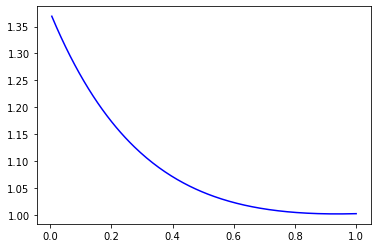

0.9400000000000001

In [107]:
# Graphing the Cost function over different values in 0 < epsilong < 1
e = np.arange(0.005,1.005, 0.005)
cost = []

for h in e:
    l = costf(h, randomized)
    cost.append(l)
    
plt.plot(e, cost, 'b')
plt.show()
j= cost.index(min(cost))
e[j]

In [92]:
def Transform(e, vec): # e value of epsilon, vec list [temp, s0, s1, s2...]
    m, W = W1(vec, e)
    W = pol(W)
    out = W2(W)
    out = pol(out)
    return out

In [105]:
# Checking the efficiency of the epsilon
def check(e, numChecks):
    i = 0
    right = 0
    wrong = 0
    while i < numChecks:
        t = r.randint(1,30)/10.0
        m = met.func(10000, 10, t)
        latt = m.flatten()
        out = Transform(e, latt)
        if (t<TJ and out[0]==1 and out[1]==0) or (t>TJ and out[0]==0 and out[0]==1):
            right += 1
        else:
            wrong +=1
        i += 1
    print('correct: '+str(right/numChecks))
    print('incorrect: '+str(wrong/numChecks))
        
check(0.94, 500)

correct: 0.57
incorrect: 0.43
